# Conditional GAN

**Autor:** [Sayak Paul](https://twitter.com/RisingSayak)<br>
**Data de criação:** 2021/07/13<br>
**Última modificação:** 2024/01/02<br>
**Descrição:** Treinar um GAN condicionado a rótulos de classe para gerar dígitos manuscritos.

Redes Adversariais Generativas (GANs) nos permitem gerar novos dados de imagem, dados de vídeo,
ou dados de áudio de uma entrada aleatória. Normalmente, a entrada aleatória é amostrada
de uma distribuição normal, antes de passar por uma série de transformações que se transformam
transformá-lo em algo plausível (imagem, vídeo, áudio, etc.).

Contudo, um simples [DCGAN](https://arxiv.org/abs/1511.06434) não nos deixa controlar
a aparência (por exemplo, classe) das amostras que estamos gerando. Por exemplo,
com um GAN que gera dígitos manuscritos MNIST, um simples DCGAN não nos permitiria
escolha a classe de dígitos que estamos gerando.
Para poder controlar o que geramos, precisamos _condicionar_ a saída GAN
em uma entrada semântica, como a classe de uma imagem.

Neste exemplo, construiremos um **GAN condicional** que pode gerar MNIST manuscrito
dígitos condicionados a uma determinada classe. Esse modelo pode ter várias aplicações úteis:
* digamos que você esteja lidando com um
[imbalanced image dataset](https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data),
e você gostaria de reunir mais exemplos da classe distorcida para equilibrar o conjunto de dados.
A coleta de dados pode ser um processo caro por si só. Em vez disso, você poderia treinar um GAN condicional e usar
para gerar novas imagens para a classe que precisa de equilíbrio.
* Como o gerador aprende a associar as amostras geradas aos rótulos das classes,
suas representações também podem ser usadas para [other downstream tasks](https://arxiv.org/abs/1809.11096).

A seguir estão as referências usadas para desenvolver este exemplo:

* [Conditional Generative Adversarial Nets](https://arxiv.org/abs/1411.1784)
* [Lecture on Conditional Generation from Coursera](https://www.coursera.org/lecture/build-basic-generative-adversarial-networks-gans/conditional-generation-inputs-2OPrG)

Se precisar de uma atualização sobre GANs, você pode consultar as "Redes adversárias geradoras"
Seção
[this resource](https://livebook.manning.com/book/deep-learning-with-python-second-edition/chapter-12/r-3/232).

Este exemplo requer o TensorFlow 2.5 ou superior, bem como o TensorFlow Docs, que pode ser
instalado usando o seguinte comando:

In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


## Importações

In [ ]:
!pip install --upgrade keras #atualiza/instala a biblioteca Keras
import keras #importa o módulo principal do Keras, uma biblioteca de aprendizado de máquina de alto nível que roda sobre o TensorFlow.

from keras import layers #importa o submódulo layers do Keras, que contém diversas camadas pré-definidas p/ a construção de modelos de redes neurais.
from keras import ops #importa o submódulo ops do Keras, que contém operações de baixo nível usadas internamente pelo Keras.
from tensorflow_docs.vis import embed # importa a função embed do submódulo vis do pacote tensorflow_docs, que fornece ferramentas para visualização de dados em TensorFlow.
import tensorflow as tf
import numpy as np #importa o NumPy, uma biblioteca para computação numérica
import imageio #importa a biblioteca imageio, que fornece uma API fácil de usar para ler e gravar uma ampla gama de formatos de imagens e vídeos

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.5 which is incompatible.


## Constantes e hiperparâmetros
O papel das constantes e dos hiperparâmetros é essencialmente fornecer uma maneira de ajustar e controlar o comportamento do modelo CGAN durante o treinamento. Enquanto as **constantes** definem os aspectos fundamentais e estáticos do modelo, os **hiperparâmetros** oferecem flexibilidade para ajustar o desempenho do modelo e otimizar sua eficácia em relação a uma tarefa específica.

A seleção adequada de hiperparâmetros é crucial para garantir que o modelo CGAN seja treinado de forma eficiente e produza resultados de alta qualidade.

**Exemplos de constantes** incluem a taxa de aprendizado inicial, o tamanho do lote de dados de treinamento, a dimensão do espaço latente (ruído) de entrada, etc.

**Exemplos de hiperparâmetros** incluem a taxa de aprendizado (que pode ser adaptativa), o número de épocas de treinamento, a arquitetura específica da rede neural (número de camadas, tamanho dos filtros, etc.), os pesos das perdas adversariais e condicionais, entre outros.

In [ ]:
batch_size = 64 #define o tamanho do lote (batch) de dados. Um tamanho de lote de 64 significa que o modelo será atualizado a cada 64 amostras de dados processadas.
num_channels = 1 #o número de canais de cor em uma imagem. 1 = não há variação de cor
num_classes = 10 #o número total de classes/categorias distintas em um problema de classificação. Ex.: conjunto de dados MNIST, que contém imagens de dígitos manuscritos, existem 10 classes, uma para cada dígito de 0 a 9.
image_size = 28 #tamanho das imagens utilizadas no modelo. No caso do MNIST, as imagens têm 28 pixels de largura e 28 pixels de altura, resultando em imagens de tamanho 28x28 pixels.
latent_dim = 128 #dimensão do espaço latente, que é uma representação abstrata e compacta de características aprendidas pelo modelo. É onde o modelo gera novas amostras, como imagens, a partir de distribuições de probabilidade latentes.

## Carregando o conjunto de dados MNIST e pré-processando-o

O **MNIST** é um conjunto de dados que consiste em imagens de dígitos manuscritos de 0 a 9. É amplamente utilizado como um benchmark em aprendizado de máquina e visão computacional. Pré-processar o conjunto de dados MNIST durante o treinamento de uma CGAN é comum porque oferece um desafio relativamente simples e bem definido para entender e experimentar com as técnicas de GANs. Isso ajuda a garantir que os dados de entrada estejam em um formato adequado para o treinamento eficaz do modelo.

In [ ]:
"Usaremos todos os exemplos disponíveis tanto do treinamento quanto do teste conjuntos."
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data() #carrega o conjunto de dados MNIST do Keras. Ele carrega os dados de treinamento (x_train, y_train) e os dados de teste (x_test, y_test) separadamente.
all_digits = np.concatenate([x_train, x_test])#os dados de treinamento e teste são concatenados para formar um único conjunto de dados all_digits. Isso é feito para usar todos os exemplos disponíveis tanto do conjunto de treinamento quanto do conjunto de teste.
all_labels = np.concatenate([y_train, y_test])#os dados de treinamento e teste são concatenados para formar um único conjunto de dados all_labels. Isso é feito para usar todos os exemplos disponíveis tanto do conjunto de treinamento quanto do conjunto de teste.

"Dimensione os valores de pixel para o intervalo [0, 1], adicione uma dimensão de canal para as imagens e codifique os rótulos."
all_digits = all_digits.astype("float32") / 255.0 #Os valores dos pixels das imagens são normalizados para o intervalo [0, 1] dividindo por 255.0.
all_digits = np.reshape(all_digits, (-1, 28, 28, 1)) #imagens são redimensionadas para ter uma dimensão de canal usando np.reshape() para que possam ser compatíveis com as operações de convolução da rede neural. O formato das imagens é (número de imagens, largura, altura, número de canais).
all_labels = keras.utils.to_categorical(all_labels, 10) #Os rótulos são codificados para que possam ser usados com eficiência em redes neurais.

"Crie tf.data.Dataset."
dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_labels)) #Um objeto tf.data.Dataset é criado a partir dos dados de entrada e rótulos.
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size) #Os dados são embaralhados usando shuffle() com um buffer de tamanho 1024 e agrupados em lotes (batch_size) usando batch().

print(f"Formato da imagem de treinamento: {all_digits.shape}")
print(f"Formato dos rótulos de treinamento: {all_labels.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Formato da imagem de treinamento: (70000, 28, 28, 1)
Formato dos rótulos de treinamento: (70000, 10)


## Calculando o número de canais de entrada para o gerador e discriminador

Em um GAN regular (incondicional), começamos amostrando o ruído (de algum
dimensão) de uma distribuição normal. No nosso caso, também precisamos levar em conta
para os rótulos de classe. Teremos que adicionar o número de classes a
os canais de entrada do gerador (entrada de ruído), bem como o discriminador
(entrada de imagem gerada).

In [ ]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

138 11


## Criando o discriminador e gerador

As definições do modelo (`discriminator`, `generator` e `ConditionalGAN`) foram
adaptado de [this example](https://keras.io/guides/customizing_what_happens_in_fit/).

In [ ]:
"Cria o discriminador."
discriminator = keras.Sequential( #Cria um modelo discriminador utilizando a API Sequencial do Keras.
    [
        keras.layers.InputLayer((28, 28, discriminator_in_channels)), #Define uma camada de entrada para o discriminador com o formato (28, 28, discriminator_in_channels), onde 28x28 é o tamanho das imagens e discriminator_in_channels é o número de canais de entrada, que foi previamente definido.
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"), #Adiciona uma camada de convolução com 64 filtros, cada um com tamanho (3, 3), usando um passo (stride) de (2, 2) e preenchimento (padding) "same" para manter o tamanho da saída igual ao tamanho da entrada.
        layers.LeakyReLU(negative_slope=0.2), #Adiciona uma camada de ativação LeakyReLU, que é uma versão modificada da ReLU que permite um pequeno gradiente para valores negativos.
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"), #Adiciona uma camada de convolução com 128 filtros, cada um com tamanho (3, 3), usando um passo (stride) de (2, 2) e preenchimento (padding) "same" para manter o tamanho da saída igual ao tamanho da entrada.
        layers.GlobalMaxPooling2D(), #Adiciona uma camada de pooling global máxima para reduzir a dimensionalidade da saída.
        layers.Dense(1), #Adiciona uma camada densa com uma unidade, que produzirá uma única saída indicando a probabilidade de a amostra ser real ou falsa.
    ],
    name="discriminator",
)

"Cria o generador."
generator = keras.Sequential( #Cria um modelo gerador utilizando a API Sequencial do Keras.
    [
        keras.layers.InputLayer((generator_in_channels,)), #Define uma camada de entrada para o gerador com o formato (generator_in_channels), onde generator_in_channels é o número de canais de entrada, que foi previamente definido.
        #  Queremos gerar 128 + coeficientes num_classes para remodelar em um mapa 7x7x(128 + num_classes).
        layers.Dense(7 * 7 * generator_in_channels),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Reshape((7, 7, generator_in_channels)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"), #Adiciona uma camada de convolução transposta com 128 filtros, cada um com tamanho (4, 4), usando um passo (stride) de (2, 2) e preenchimento (padding) "same".
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"), #Adiciona uma camada de convolução com 1 filtro, cada um com tamanho (7, 7), e ativação sigmoid para produzir a imagem gerada com valores entre 0 e 1.
    ],
    name="generator",
)

## Criando um modelo `ConditionalGAN`

In [ ]:
#O código define uma classe CGAN que implementa uma GAN condicional utilizando o framework Keras.
#Nesta GAN, tanto o gerador quanto o discriminador são condicionados aos rótulos de classe.
#O método train_step realiza uma etapa de treinamento personalizada, onde os dados são preparados, o discriminador e o gerador são
 #treinados alternadamente e as perdas são atualizadas.
#A classe também define métricas para monitorar as perdas do gerador e do discriminador durante o treinamento.

class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        "Descompacte os dados"
        real_images, one_hot_labels = data

        "Adicione dimensões fictícias aos rótulos para que possam ser concatenadas com as imagens. Isto é para o discriminador."
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = ops.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = ops.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        "Amostra pontos aleatórios no espaço latente e concatena os rótulos. Isto é para o gerador."
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        "Decodifique o ruído (guiado por rótulos) para imagens falsas."
        generated_images = self.generator(random_vector_labels)

        "Combine-os com imagens reais. Observe que estamos concatenando os rótulos com essas imagens aqui."
        fake_image_and_labels = ops.concatenate(
            [generated_images, image_one_hot_labels], -1
        )
        real_image_and_labels = ops.concatenate([real_images, image_one_hot_labels], -1)
        combined_images = ops.concatenate(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        "Monte rótulos discriminando imagens reais de imagens falsas."
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )

        "Treine o discriminador"
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        "Amostra de pontos aleatórios no espaço latente."
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        " Monte etiquetas que digam : todas as imagens reais."
        misleading_labels = ops.zeros((batch_size, 1))

        "Treine o gerador (observe que *não* devemos atualizar os pesos do discriminador)!"
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = ops.concatenate(
                [fake_images, image_one_hot_labels], -1
            )
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        "Monitore a perda."
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }


## Treinando o GAN Condicional

In [ ]:
#cria uma instância de uma GAN condicional, configura-a para treinamento com otimizadores e função de perda especificados, e, em seguida,
#inicia o treinamento do modelo com o conjunto de dados fornecido, realizando 20 épocas de treinamento.

cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

cond_gan.fit(dataset, epochs=20)

Epoch 1/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 52s 29ms/step - d_loss: 0.4533 - g_loss: 1.3762 - discriminator_loss: 0.4759 - generator_loss: 1.3197
Epoch 2/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 60s 24ms/step - d_loss: 0.4923 - g_loss: 1.2914 - discriminator_loss: 0.4862 - generator_loss: 1.3143
Epoch 3/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - d_loss: 0.3901 - g_loss: 1.6758 - discriminator_loss: 0.3294 - generator_loss: 1.9271
Epoch 4/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - d_loss: 0.2144 - g_loss: 2.2847 - discriminator_loss: 0.2629 - generator_loss: 2.2636
Epoch 5/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 42s 24ms/step - d_loss: 0.6239 - g_loss: 1.0447 - discriminator_loss: 0.6059 - generator_loss: 1.0499
Epoch 6/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - d_loss: 0.6175 - g_loss: 0.9922 - discriminator_loss: 0.6304 - generator_loss: 0.9530
Epoch 7/20
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - d_loss: 0.6495 - g_loss: 0.8749 - discriminator_loss: 0.6544 - generator_loss:

## Interpolando entre classes com o gerador treinado

In [ ]:
"Primeiro extraímos o gerador treinado de nosso GAN condicional."
trained_gen = cond_gan.generator

"Escolha o número de imagens intermediárias que seriam geradas em"
"entre a interpolação + 2 (inicial e última imagem)."
#Define o número de imagens intermediárias que serão geradas
# entre a primeira e a última imagem durante a interpolação.
num_interpolation = 200  # @param {type:"integer"}

" Amostra de ruído para a interpolação."
interpolation_noise = keras.random.normal(shape=(1, latent_dim))
interpolation_noise = ops.repeat(interpolation_noise, repeats=num_interpolation)
interpolation_noise = ops.reshape(interpolation_noise, (num_interpolation, latent_dim))

def interpolate_class(first_number, second_number):
    "Converta os rótulos de início e fim em vetores codificados one-hot."
    first_label = keras.utils.to_categorical([first_number], num_classes)
    second_label = keras.utils.to_categorical([second_number], num_classes)
    first_label = ops.cast(first_label, "float32")
    second_label = ops.cast(second_label, "float32")

    "Calcule o vetor de interpolação entre os dois rótulos."
    percent_second_label = ops.linspace(0, 1, num_interpolation)[:, None]
    percent_second_label = ops.cast(percent_second_label, "float32")
    interpolation_labels = (
        first_label * (1 - percent_second_label) + second_label * percent_second_label
    )

    "Combine o ruído e os rótulos e execute a inferência com o gerador."
    "gera as imagens interpoladas, utilizando os vetores combinados de ruído e rótulo"
    noise_and_labels = ops.concatenate([interpolation_noise, interpolation_labels], 1)
    fake = trained_gen.predict(noise_and_labels)
    return fake


start_class = 6  # @param {type:"slider", min:0, max:9, step:1}
end_class = 7  # @param {type:"slider", min:0, max:9, step:1}

fake_images = interpolate_class(start_class, end_class)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Aqui, primeiro amostramos o ruído de uma distribuição normal e depois repetimos isso para
`num_interpolation` vezes e remodelar o resultado de acordo.
Em seguida, distribuímos uniformemente para `num_interpolation`
com as identidades do rótulo estando presentes em alguma proporção.



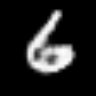

In [ ]:
fake_images *= 255.0 #Multiplica todas as intensidades de pixel das imagens interpoladas por 255 para reverter a normalização feita anteriormente.
converted_images = fake_images.astype(np.uint8) #Converte as imagens interpoladas para o tipo de dados uint8 = imagens de 8 bits por canal.
converted_images = ops.image.resize(converted_images, (96, 96)).numpy().astype(np.uint8) #Redimensiona as imagens interpoladas para um tamanho de 96x96 pixels, utilizando a função resize do TensorFlow.Converte o resultado de volta para um array NumPy e, em seguida, para o tipo de dados uint8
imageio.mimsave("animation.gif", converted_images[:, :, :, 0], fps=1) #Salva as imagens interpoladas como um arquivo GIF chamado "animation.gif".
#Acessa apenas o primeiro canal das imagens (o canal de intensidade) e ignora os outros canais, pois estamos trabalhando com imagens em escala de cinza.
#Define a taxa de quadros (frames per second - fps) como 1.
embed.embed_file("animation.gif") #Mostra o arquivo GIF animado na saída do código

Podemos melhorar ainda mais o desempenho deste modelo com receitas como
[WGAN-GP](https://keras.io/examples/generative/wgan_gp).
A geração condicional também é amplamente utilizada em muitas arquiteturas modernas de geração de imagens, como
[VQ-GANs](https://arxiv.org/abs/2012.09841), [DALL-E](https://openai.com/blog/dall-e/),
etc.

Você pode usar o modelo treinado hospedado no [Hugging Face Hub](https://huggingface.co/keras-io/conditional-gan) e experimentar a demonstração no [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/conditional-GAN).